# Primeiro trabalho computacional - Noções de Inteligência Artificial
Miguel Mendes Luna - 211026501;
Pedro Eduardo Cunha Ximenes - 200026071

In [484]:
import pandas as pd
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
from d2l import tensorflow as d2l
import random

In [485]:
class LinearRegression(d2l.Module):  #@save
    """The linear regression model implemented with high-level APIs."""
    """Do d2l"""
    def __init__(self, lr):
        super().__init__()
        self.save_hyperparameters()
        initializer = tf.initializers.RandomNormal(stddev=0.01)
        self.net = tf.keras.layers.Dense(1, kernel_initializer=initializer)

In [486]:
class LinearRegressionData(d2l.DataModule):  #@save
    """Data for linear regression."""
    def __init__(self, nInputs,data,num_train=5197, num_val=1300,
                 batch_size=32):
        super().__init__()
        self.save_hyperparameters()
        self.X=data[:,0:nInputs]
        self.y=data[:,nInputs]

In [487]:
beer_df = pd.read_csv("Beer.csv")
# beer_df.info()
beer_df

,Fermentation_Time,Temperature,pH_Level,Gravity,Alcohol_Content,Bitterness,Color,Quality_Score
0,16,24.204251,5.289845,1.039504,5.370842,20,5,8
1,13,18.086763,5.275643,1.059819,5.096053,36,14,7
2,12,15.539333,4.778016,1.037476,4.824737,30,10,8
3,17,16.418489,5.345261,1.052431,5.509243,48,18,9
4,18,19.144908,4.861854,1.054296,5.133625,57,13,7
...,...,...,...,...,...,...,...,...
25152,12,24.162997,5.028789,1.065747,4.719395,59,8,8
25153,14,17.345413,4.589591,1.074461,5.994881,56,13,8
25154,18,24.752707,4.750171,1.036131,4.811326,52,16,6
25155,19,19.723599,4.953446,1.045640,5.825491,22,19,9


Devemos separar os dados em dados característicos (da coluna 1 a coluna 7, representado por x) e o dado preditor (coluna 8, representado por y)

In [488]:
@d2l.add_to_class(d2l.DataModule)  #@save
def get_tensorloader(self, tensors, train, indices=slice(0, None)):
    tensors = tuple(a[indices] for a in tensors)
    shuffle_buffer = tensors[0].shape[0] if train else 1
    return tf.data.Dataset.from_tensor_slices(tensors).shuffle(
        buffer_size=shuffle_buffer).batch(self.batch_size)

@d2l.add_to_class(LinearRegressionData)  #@save
def get_dataloader(self, train):
    i = slice(0, self.num_train) if train else slice(self.num_train, None)
    return self.get_tensorloader((self.X, self.y), train, i)

In [489]:
train_data, val_data = train_test_split(beer_df.values, test_size=0.2)
train_data.shape, val_data.shape 

((20125, 8), (5032, 8))

In [490]:
@d2l.add_to_class(LinearRegression)  #@save
def forward(self, X):
    return self.net(X)

In [491]:
@d2l.add_to_class(LinearRegression)  #@save
def loss(self, y_hat, y):
    fn = tf.keras.losses.MeanSquaredError()
    return fn(y, y_hat)

In [492]:
@d2l.add_to_class(LinearRegression)  #@save
def configure_optimizers(self):
    return tf.keras.optimizers.SGD(self.lr)

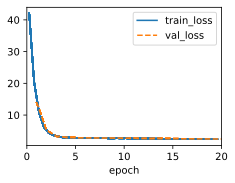

In [493]:
#Treinamento
model = LinearRegression(lr=0.000001)
initialized_data = LinearRegressionData(nInputs=7,data=train_data)
trainer = d2l.Trainer(max_epochs=20)
trainer.fit(model, initialized_data)

In [494]:
#Previsões do modelo
val_inputs = val_data[:,0:7] #As primeiras 7 colunas são as entradas
val_targets = val_data[:,7] #A última coluna é o alvo
predictions = model.call(val_inputs)

#Erro absoluto médio
mean = tf.reduce_mean(predictions - val_targets)

#Preditor trivial, média dos dados alvo de validação
trivial_predictions = np.mean(val_data[:,7])
trivial_mean = np.mean(trivial_predictions - val_targets)

#Classificação por arredondamento
rounded_prediction = tf.round(predictions)
round_error = tf.reduce_mean(rounded_prediction - val_targets)

print(f"Erro Absoluto Médio do modelo: {mean}")
print(f"Erro Absoluto Médio do preditor trivial: {trivial_mean}")
print(f"Erro na classificação por arredondamento: {round_error}")

Erro Absoluto Médio do modelo: -0.19456949830055237
Erro Absoluto Médio do preditor trivial: -4.1373017006698996e-16
Erro na classificação por arredondamento: -0.18879173696041107


In [495]:
def correct_rate(ref, pred):
    if not ref or not pred:
        return 0

    # A função min é usada para garantir que só consideramos o número de comparações até o tamanho da menor lista
    min_size = min(len(ref), len(pred))
    
    # Contar quantos elementos correspondem exatamente na mesma posição
    corrects = sum(1 for i in range(min_size) if ref[i] == pred[i])
    
    # Calcular a taxa de acerto com base no tamanho da lista de referência
    rate = (corrects / len(ref)) * 100
    return rate

# Exemplo de uso:
reference = val_targets.tolist()
prediction = rounded_prediction.numpy().flatten().tolist()
print(f'Taxa de Acerto: {correct_rate(reference, prediction):.2f}%')

Taxa de Acerto: 24.48%


In [496]:
correlation = np.corrcoef(reference, prediction)
print(f'A correlação é : {correlation[0][1]}')
correlation

A correlação é : 0.02076003219754153


array([[1.        , 0.02076003],
       [0.02076003, 1.        ]])